<a href="https://colab.research.google.com/github/lennonchaves/llm-fine-tuning-rag/blob/main/TPFinal_Lennon_Chaves_Etapa_Parte1_Parte2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Trabalho Final de NLP**
**Disciplina:** Tópicos Especiais em Recuperação de Informação (TERI) - NLP

**Aluno:** Lennon Correa Chaves

**Matrícula:** 3240097

**Entregável:**
- Leitura e Pré-Processamento de Dados
- Geração da Base de Dados Sintética


# Parte 1: Leitura e Pré-Processamento de Dados

Instalação dos pacotes necessários para realização da leitura de todos os arquivos contendo normas e legislação

In [ ]:
!apt-get install tesseract-ocr
!pip install pytesseract
!pip install PyMuPDF
!pip install beautifulsoup4
!pip install requests
!pip install Pillow
!pip install nltk
!pip install spacy
!python -m spacy download pt_core_news_sm
!pip install openai==0.28

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (5,533 kB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 123598 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-

Processamento da base de dados:

* Extração dos arquivos;
* Transformação dos arquivos para texto


In [ ]:
import requests
from bs4 import BeautifulSoup
import fitz
import pytesseract
from io import BytesIO
from PIL import Image

count = 0

# Configurar o pytesseract para apontar para o executável do Tesseract
pytesseract.pytesseract.tesseract_cmd = '/usr/bin/tesseract'

# URLs com páginas HTML que contêm os arquivos PDF com a legislação UFAM
url_list = [
    'https://proeg.ufam.edu.br/normas-academicas/57-proeg/146-legislacao-e-normas.html',
    'https://edoc.ufam.edu.br/handle/123456789/917',
    'https://edoc.ufam.edu.br/handle/123456789/927',
    'https://edoc.ufam.edu.br/handle/123456789/928',
    'https://edoc.ufam.edu.br/handle/123456789/937',
    'https://proeg.ufam.edu.br/dpa/legislacao-estagio.html'
]

# Função para extrair texto de PDFs, incluindo PDFs escaneados
def extract_text_from_pdf(pdf_content):
    text = ""
    pdf_document = fitz.open(stream=pdf_content, filetype="pdf")

    for page_num in range(len(pdf_document)):
        page = pdf_document[page_num]
        page_text = page.get_text()
        text += page_text

        # Se não houver texto extraído, tentamos OCR
        if not page_text.strip():
            pix = page.get_pixmap()
            img = Image.open(BytesIO(pix.tobytes()))
            text += pytesseract.image_to_string(img)

    return text

# Lista para armazenar os conteúdos dos links
link_contents = []

# Fazendo a requisição HTTP para obter o conteúdo da página
for url in url_list:
    response = requests.get(url)
    if response.status_code == 200:
        page_content = response.text

        # Usando BeautifulSoup para analisar o HTML
        soup = BeautifulSoup(page_content, 'html.parser')

        # Encontrar todos os links na página HTML
        links = soup.find_all('a')

        # Coleção para armazenar todos os links que contêm PDF e sem repetições
        links_list = set()

        # Iterar sobre os links e extrair o conteúdo
        for link in links:
            link_url = link.get('href')
            # Verifica se a URL é um arquivo PDF
            if link_url and link_url.endswith('.pdf'):
                # Verifica se a URL está incompleta ou não
                if link_url.startswith('/bitstream'):
                    link_url = 'https://edoc.ufam.edu.br' + link_url
                links_list.add(link_url)

        for link_url in links_list:
            # Fazendo a requisição HTTP para obter o conteúdo do PDF
            link_response = requests.get(link_url)
            # Verificando se a requisição foi bem-sucedida
            if link_response.status_code == 200:
                pdf_content = link_response.content
                pdf_text = extract_text_from_pdf(pdf_content)
                link_contents.append({
                    'url': link_url,
                    'content': pdf_text
                })
                count += 1
                print(f'Lendo o arquivo {count} - URL: {link_url}')
            else:
                print(f'Falha ao acessar o link: {link_url}. Status code: {link_response.status_code}')
    else:
        print(f'Falha ao acessar a página: {url}. Status code: {response.status_code}')

print("Leitura Completa.")

Lendo o arquivo 1 - URL: https://edoc.ufam.edu.br/bitstream/123456789/1008/115/CARTA%20DE%20SERVI%c3%87OS%20VERS%c3%83O%20FEV%202024.pdf
Lendo o arquivo 2 - URL: https://edoc.ufam.edu.br/bitstream/123456789/5334/17/RES%2008_2015%20NOME%20SOCIAL.pdf
Lendo o arquivo 3 - URL: https://edoc.ufam.edu.br/bitstream/123456789/5334/11/PORT%2053%20PLANO%20DE%20A%c3%87%c3%83O%20CURSOS_2018.pdf
Lendo o arquivo 4 - URL: http://edoc.ufam.edu.br/bitstream/123456789/908/5/RESOLU%c3%87%c3%83O_CNE_DIRETCURRICNACIONAIS%20OUT2019.pdf
Lendo o arquivo 5 - URL: https://edoc.ufam.edu.br/bitstream/123456789/5387/61/LEI%20CARTEIRA%20ESTUDANTIL.pdf
Lendo o arquivo 6 - URL: https://edoc.ufam.edu.br/bitstream/123456789/5334/18/RES%2010_2016%20DISCIPLINAS%20PRESENCIAIS.pdf
Lendo o arquivo 7 - URL: https://edoc.ufam.edu.br/bitstream/123456789/5334/32/RES%2064_2011%20PRIIMES.pdf
Lendo o arquivo 8 - URL: https://edoc.ufam.edu.br/bitstream/123456789/5334/13/PORT%20%2004_2002%20PRAZO%20RET%20DOCUMENTOS.pdf
Lendo o arquiv

Pre-Processamento da Base de Dados:
* Conversão para letras minúsculas
* Remoção de números, pontuação e espaços em branco extra
* Remoção de stop words e palavras de uma letra
* Remoção de palavras não conhecidas



In [ ]:
import re
import nltk
from nltk.corpus import stopwords
import spacy
import string

# Baixar a lista de stopwords em português
nltk.download('stopwords')
nltk.download('punkt')

# Carregar as stopwords em português
stop_words = set(stopwords.words('portuguese'))

# Carregar o modelo de linguagem do spaCy para português
nlp = spacy.load('pt_core_news_sm')
known_words = set(nlp.vocab.strings)

# Função para limpeza, normalização e pré-processamento dos textos escaneados
def preprocess_text(text):
    """
    Função para pré-processar texto para tarefas de NLP.

    Args:
    text (str): Texto bruto a ser processado.

    Returns:
    str: Texto pré-processado.
    """
    # Converter para minúsculas
    text = text.lower()

    # Remover números
    text = re.sub(r'\d+', '', text)

    # Remover pontuação
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remover espaços em branco extras
    text = text.strip()

    # Tokenização
    tokens = nltk.word_tokenize(text)

    # Remover stopwords
    tokens = [word for word in tokens if word not in stop_words]

    # Remover palavras de uma letra
    tokens = [word for word in tokens if len(word) > 1]

    # Remover palavras desconhecidas
    tokens = [word for word in tokens if word in known_words]

    # Juntar os tokens de volta em uma string
    preprocessed_text = ' '.join(tokens)

    return preprocessed_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Aplicação da função de pré-processamento nos arquivos PDFs lidos

In [ ]:
# Aplicar pré-processamento ao conteúdo de cada item
count = 0
for item in link_contents:
    item['content'] = preprocess_text(item['content'])
    count += 1
    print(f'Aquivo {count} foi pre-processado com sucesso!')

Aquivo 1 foi pre-processado com sucesso!
Aquivo 2 foi pre-processado com sucesso!
Aquivo 3 foi pre-processado com sucesso!
Aquivo 4 foi pre-processado com sucesso!
Aquivo 5 foi pre-processado com sucesso!
Aquivo 6 foi pre-processado com sucesso!
Aquivo 7 foi pre-processado com sucesso!
Aquivo 8 foi pre-processado com sucesso!
Aquivo 9 foi pre-processado com sucesso!
Aquivo 10 foi pre-processado com sucesso!
Aquivo 11 foi pre-processado com sucesso!
Aquivo 12 foi pre-processado com sucesso!
Aquivo 13 foi pre-processado com sucesso!
Aquivo 14 foi pre-processado com sucesso!
Aquivo 15 foi pre-processado com sucesso!
Aquivo 16 foi pre-processado com sucesso!
Aquivo 17 foi pre-processado com sucesso!
Aquivo 18 foi pre-processado com sucesso!
Aquivo 19 foi pre-processado com sucesso!
Aquivo 20 foi pre-processado com sucesso!
Aquivo 21 foi pre-processado com sucesso!
Aquivo 22 foi pre-processado com sucesso!
Aquivo 23 foi pre-processado com sucesso!
Aquivo 24 foi pre-processado com sucesso!
A

Salvando os resultados processados em um arquivo CSV


In [ ]:
import csv

# Salvando os resultados em um arquivo CSV
with open('pdf_contents.csv', 'w', encoding='utf-8', newline='') as csvfile:
    fieldnames = ['id', 'pdf_file', 'pdf_content']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for id, item in enumerate(link_contents, start=1):
        writer.writerow({'id': id, 'pdf_file': item['url'], 'pdf_content': item['content']})

print("Resultados salvos em 'pdf_contents.csv'")

Resultados salvos em 'pdf_contents.csv'


**Estatíticas da Base de Dados**
- Quantidade de tokens
- Quantidade de tokens unicos
- Tamanho do vocabulario
- 20 tokens mais frequents
- Diversidade do corpus
- Plot estilo histograma com os 20 tokens mais fequentes
- Plot estilo histograma com 20 documentos com mais tokens

Quantidade total de tokens: 58012
Quantidade de tokens únicos: 5815
Tamanho do vocabulário: 5815
Diversidade do corpus: 0.1002
20 tokens mais frequentes (termo, frequência):

ensino: 1050

art: 979

educação: 723

universidade: 545

curso: 531

federal: 445

cursos: 404

amazonas: 382

graduação: 324

formação: 321

lei: 301

superior: 298

pesquisa: 281

conselho: 278

atividades: 274

considerando: 222

iii: 208

aluno: 197

trabalho: 187

estágio: 186



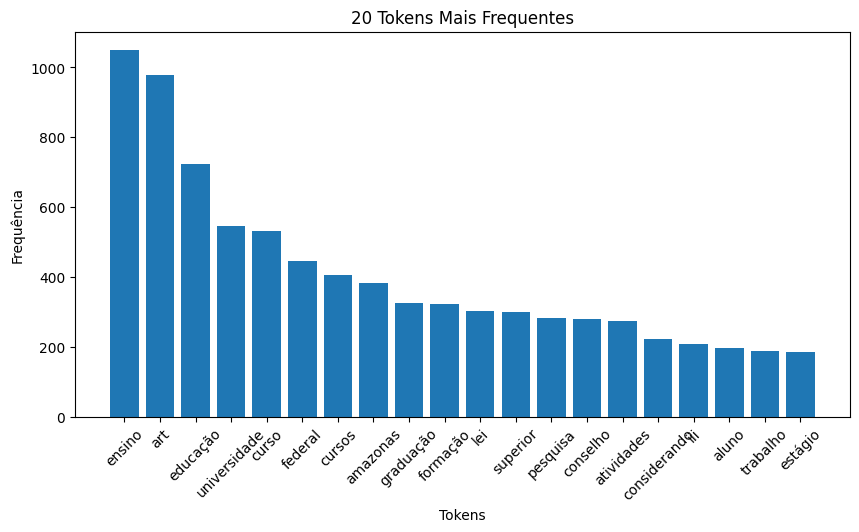

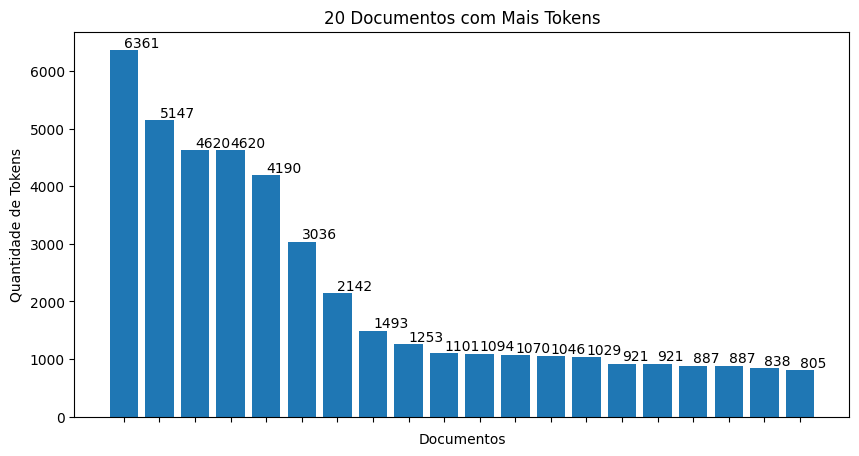

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize

# Função de processamento
def analyze_contents(df):

    # Adicionar uma coluna de índice para os documentos
    df['document_number'] = df.index + 1

    # Tokenização dos conteúdos
    df['tokens'] = df['content'].apply(word_tokenize)

    # Quantidade de tokens por item da lista
    df['token_count'] = df['tokens'].apply(len)

    # Criação de um único vetor com todos os tokens
    all_tokens = [token for sublist in df['tokens'] for token in sublist]

    # Quantidade total de tokens
    total_tokens = len(all_tokens)

    # Quantidade de tokens únicos
    unique_tokens = len(set(all_tokens))

    # Tamanho do vocabulário
    vocabulary_size = unique_tokens

    # Contagem de frequência dos tokens com tamanho maior que 2
    filtered_tokens = [token for token in all_tokens if len(token) > 2]
    token_freq = Counter(filtered_tokens)

    # 20 tokens mais frequentes
    most_common_tokens = token_freq.most_common(20)

    # Diversidade do corpus
    corpus_diversity = unique_tokens / total_tokens

    # Exibição dos resultados
    print(f"Quantidade total de tokens: {total_tokens}")
    print(f"Quantidade de tokens únicos: {unique_tokens}")
    print(f"Tamanho do vocabulário: {vocabulary_size}")
    print(f"Diversidade do corpus: {corpus_diversity:.4f}")
    print("20 tokens mais frequentes (termo, frequência):\n")
    for term, freq in most_common_tokens:
        print(f"{term}: {freq}\n")


    # Plot com os 20 tokens mais frequentes
    tokens, frequencies = zip(*most_common_tokens)
    plt.figure(figsize=(10, 5))
    plt.bar(tokens, frequencies)
    plt.title('20 Tokens Mais Frequentes')
    plt.xlabel('Tokens')
    plt.ylabel('Frequência')
    plt.xticks(rotation=45)
    plt.show()

    # Plot com 20 documentos com mais tokens
    top_20_items = df.nlargest(20, 'token_count').sort_values(by='token_count', ascending=False)
    plt.figure(figsize=(10, 5))
    bars = plt.bar(range(len(top_20_items)), top_20_items['token_count'])
    plt.title('20 Documentos com Mais Tokens')
    plt.xlabel('Documentos')
    plt.ylabel('Quantidade de Tokens')
    plt.xticks(range(len(top_20_items)), [''] * len(top_20_items))  # Eixo x sem nada

    # Adicionando valores no topo das barras
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom')  # Adiciona o valor

    plt.show()
# Chamando a função com o DataFrame
data = pd.DataFrame(link_contents)
analyze_contents(data)


# Parte 2: Geração de Base de Dados Sintetica

Código para geração da base de dados sintética:
* Carregamento do arquivo CSV com os PDFs pré-processados
* Utilização do GPT para geração da base de dados sintética
* Base sintética com 1000 perguntas e respostas geradas em database_sintetica.csv (atributos: pergunta, resposta)

In [ ]:
import csv
import openai
import random
import pandas as pd

# Configurar a chave de API da OpenAI
openai.api_key = 'OPENAI_KEY'

# Lendo o arquivo CSV com os PDFs pré-processados para carregá-los antes de gerar a base sintética
pdf_contents = []
with open('pdf_contents.csv', 'r', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        pdf_contents.append({
            'url': row['pdf_file'],
            'content': row['pdf_content']
        })

# Função para gerar perguntas e respostas usando um modelo de linguagem
def gerar_pergunta_resposta(conteudo):
    # Construindo o prompt para o modelo de linguagem
    prompt = f"Baseado no seguinte conteúdo: \"{conteudo}\". Gere uma pergunta e sua resposta em no máximo 500 caracteres."
    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "Você é um assistente especialista em criar perguntas e respostas sobre a legislação da Universidade Federal do Amazonas."},
            {"role": "user", "content": prompt}
        ],
        max_tokens=1000,
        n=1,
        stop=None,
        temperature=0.9,  # Aumenta a criatividade
        top_p=0.95,       # Uso de nucleus sampling
        frequency_penalty=0.5,  # Penalidade por repetição de palavras
        presence_penalty=0.6    # Incentiva a introdução de novos conceitos
    )
    resposta_gerada = response.choices[0].message['content'].strip()
    return resposta_gerada.split('\n', 1)

database_sintetica = []

count = 0
# Geração de 1000 exemplos de perguntas e respostas
for _ in range(1000):
    # Seleciona um conteúdo aleatório das normas acadêmicas pré-processadas
    item = random.choice(pdf_contents)
    conteudo = item['content']

    # Gera uma pergunta e resposta
    pergunta_resposta = gerar_pergunta_resposta(conteudo)
    if len(pergunta_resposta) == 2:
        pergunta, resposta = pergunta_resposta
        database_sintetica.append({
            'pergunta': pergunta,
            'resposta': resposta
        })
    count += 1
    print(f'Pergunta/Resposta {count} gerada com sucesso!')

# Criando um DataFrame a partir da base de dados sintética
df = pd.DataFrame(database_sintetica)

# Salvando o DataFrame em um arquivo CSV
df.to_csv('database_sintetica.csv', index=False, encoding='utf-8')

print("Base de dados sintética gerada e salva em 'database_sintetica.csv'")

Pergunta 1 gerada com sucesso!
Pergunta 2 gerada com sucesso!
Pergunta 3 gerada com sucesso!
Pergunta 4 gerada com sucesso!
Pergunta 5 gerada com sucesso!
Pergunta 6 gerada com sucesso!
Pergunta 7 gerada com sucesso!
Pergunta 8 gerada com sucesso!
Pergunta 9 gerada com sucesso!
Pergunta 10 gerada com sucesso!
Pergunta 11 gerada com sucesso!
Pergunta 12 gerada com sucesso!
Pergunta 13 gerada com sucesso!
Pergunta 14 gerada com sucesso!
Pergunta 15 gerada com sucesso!
Pergunta 16 gerada com sucesso!
Pergunta 17 gerada com sucesso!
Pergunta 18 gerada com sucesso!
Pergunta 19 gerada com sucesso!
Pergunta 20 gerada com sucesso!
Pergunta 21 gerada com sucesso!
Pergunta 22 gerada com sucesso!
Pergunta 23 gerada com sucesso!
Pergunta 24 gerada com sucesso!
Pergunta 25 gerada com sucesso!
Pergunta 26 gerada com sucesso!
Pergunta 27 gerada com sucesso!
Pergunta 28 gerada com sucesso!
Pergunta 29 gerada com sucesso!
Pergunta 30 gerada com sucesso!
Pergunta 31 gerada com sucesso!
Pergunta 32 gerad